<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter12/Face_generation_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using DCGAN to generate face images
Convolutional Neural Networks (CNNs) perform better in the context of images when compared to vanilla neural networks.  
in this notebook we'll generate face images using Deep Convolutional Generative Adversarial Networks (DCGANs), which use convolution and pooling operations in the model.  

The steps:
1. convert noise into a shape of batch size x 100 x 1 x 1. The reason for appending additional channel information in DCGANs and not doing it in the GAN section is that we will leverage CNNs in this section, which requires inputs in the form of batch size x channels x height x width.  
2. convert the generated noise into an image by leveraging ConvTranspose2d (take input with a smaller feature map size (height x width) and upsample it to that of a larger size using a predefined kernel size, stride, and padding). This way, we would gradually convert a vector from a shape of batch size x 100 x 1 x 1 into a shape of batch size x 3 x 64 x 64.  




In [1]:
!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2022-07-15 12:52:44--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6020:18::a27d:4012, 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6020:18::a27d:4012|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2022-07-15 12:52:44--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc36585fe19fab5f6afbb08d84b1.dl.dropboxusercontent.com/cd/0/inline/BpEsmzHHflAzMxMkgZh6u5vf5MekDoEaNdCgpDQqdJNORAgCFHBetBA2m1G2VjuSeNt93ASJ2PBZZTD_U7JtKqcZC5QgXXWpZCmE5mpKnJlGhsXxdYjvT60moN49TiKeKQNxfPkfgLTVUNmG8zwHBKMVQ9S1ObfCi1FD9nXFqsmC_A/file# [following]
--2022-07-15 12:52:45--  https://uc36585fe19fab5f6afbb08d84b1.dl.dropboxusercontent.com/cd/0/inline/BpEs

In [2]:
# !pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

Ensure that we crop the images so that we retain only the faces and discard additional details in the image

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [19]:
# !mkdir cropped_faces
images = Glob('./females/*.jpg')+Glob('./males/*.jpg')
n_cropped_faces = 0
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        n_cropped_faces += 1
        img2 = img[y:(y+h),x:(x+w),:]
        cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
print(f'scanned {len(images)} images, found {n_cropped_faces} faces')

scanned 28636 images, found 27303 faces


In [20]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [21]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [22]:
ds = Faces(folder='cropped_faces/')

In [23]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

TODO: check if the following weight initialization is part of the DCGAN paper

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

note how we initialize the weights in the `Discrimimnator` class

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        # what does self.apply mean ?
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [26]:
# !pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [29]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [30]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [31]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000	d_loss: 0.656	g_loss: 9.227	(43.42s - 1042.10s remaining))
EPOCH: 2.000	d_loss: 0.592	g_loss: 6.075	(89.32s - 1027.21s remaining))
EPOCH: 3.000	d_loss: 0.544	g_loss: 4.810	(134.93s - 989.50s remaining)))
EPOCH: 4.000	d_loss: 0.563	g_loss: 4.087	(180.78s - 949.08s remaining))
EPOCH: 5.000	d_loss: 0.573	g_loss: 3.673	(226.60s - 906.38s remaining)
EPOCH: 6.000	d_loss: 0.600	g_loss: 3.499	(272.47s - 862.81s remaining))
EPOCH: 7.000	d_loss: 0.606	g_loss: 3.339	(318.32s - 818.53s remaining)
EPOCH: 8.000	d_loss: 0.655	g_loss: 3.215	(364.27s - 774.07s remaining)
EPOCH: 9.000	d_loss: 0.592	g_loss: 3.093	(410.24s - 729.31s remaining)
EPOCH: 10.000	d_loss: 0.629	g_loss: 3.080	(456.15s - 684.23s remaining)
EPOCH: 11.000	d_loss: 0.600	g_loss: 2.997	(501.98s - 638.89s remaining)
EPOCH: 12.000	d_loss: 0.600	g_loss: 3.057	(547.86s - 593.52s remaining))
EPOCH: 13.000	d_loss: 0.569	g_loss: 3.022	(593.73s - 548.06s remaining)
EPOCH: 14.000	d_loss: 0.564	g_loss: 3.073	(639.69s - 502.61s remai

100%|██████████| 126/126 [00:00<00:00, 405.35it/s]


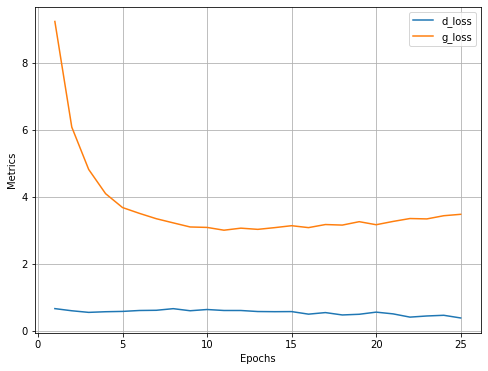

In [32]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

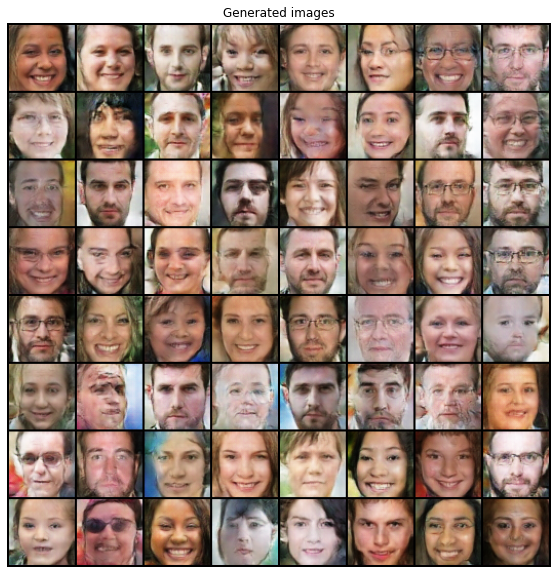

In [33]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

Note that while the generator generated images of a face from random noise, the images are decent but still not sufficiently realistic. One potential reason is that not all input images have the same face alignment.   

**As an exercise**, we suggest you train the DCGAN only on those images where there is no tilted face and the person is looking straight into the camera in the original image.  
Q: How do we select those images ? is there an attribute assigned to the images to check tilt and straight look ahead ?

In addition, we suggest you try and contrast the generated images with high discriminator scores to the ones with low discriminator scores.   
Q: What does it mean to contrast ?